In [ ]:
import cv2
import numpy as np
import json
import os
from google.colab.patches import cv2_imshow


def load_labels(file_path):
    with open(file_path, 'r') as f:
        label_data = json.load(f)
    return label_data

def convert_bbox_to_yolo(bbox, img_width, img_height):
    _, x1, y1, x2, y2, _ = bbox
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return (x_center, y_center, width, height)

def display_image_with_annotations(image_path, bbox_coordinates, labels):
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]
    for bbox, label in zip(bbox_coordinates, labels):
        x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2_imshow(image)

def process_files(image_dir, bbox_dir, label_dir, output_dir):
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            img_height, img_width = image.shape[:2]
            base_name = os.path.splitext(filename)[0]

            bbox_file_path = os.path.join(bbox_dir, f'bounding_box_2d_tight_{base_name[4:]}.npy')
            label_file_path = os.path.join(label_dir, f'bounding_box_2d_tight_labels_{base_name[4:]}.json')

            bboxes = np.load(bbox_file_path)
            labels = load_labels(label_file_path)

            yolo_data = []
            for bbox in bboxes:
                class_id = int(bbox[0])  # Assuming class ID is the first number in bbox
                yolo_bbox = convert_bbox_to_yolo(bbox, img_width, img_height)
                yolo_data.append(f"{class_id} {' '.join(map(str, yolo_bbox))}")

            output_path = os.path.join(output_dir, f'{base_name}.txt')
            with open(output_path, 'w') as f:
                f.write('\n'.join(yolo_data))

# Define your directories
image_dir = '/content/'
bbox_dir = '/content/'
label_dir = '/content/'
output_dir = '/content/yolo'

process_files(image_dir, bbox_dir, label_dir, output_dir)


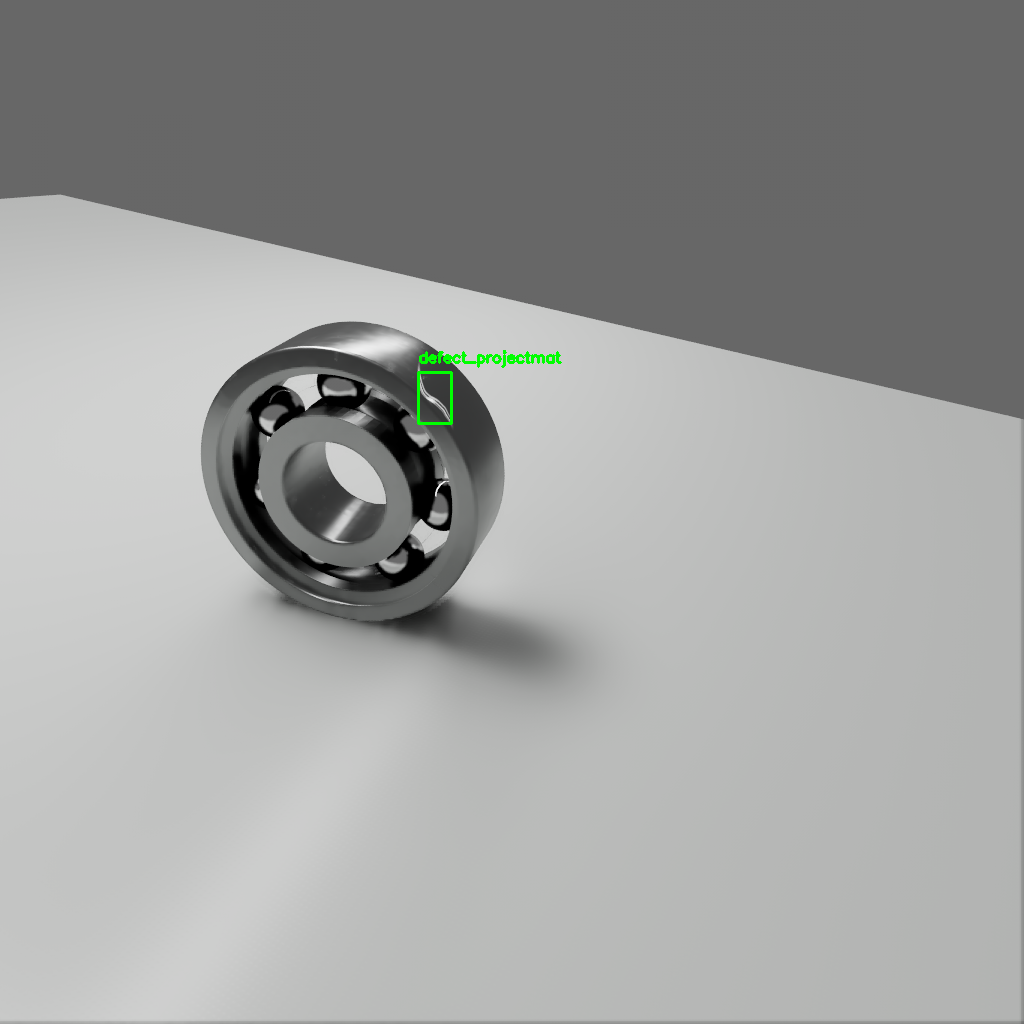

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def convert_bbox_to_yolo(bbox, img_width, img_height):
    _, x1, y1, x2, y2, _ = bbox
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

def convert_yolo_to_bbox(yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox
    x1 = int((x_center - width / 2) * img_width)
    y1 = int((y_center - height / 2) * img_height)
    x2 = int((x_center + width / 2) * img_width)
    y2 = int((y_center + height / 2) * img_height)
    return x1, y1, x2, y2

def display_image_with_annotations(image_path, bbox_file_path, label_file_path):
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]
    bbox_coordinates = np.load(bbox_file_path)
    labels = load_labels_from_json(label_file_path)

    for bbox, label in zip(bbox_coordinates, labels):
        yolo_bbox = convert_bbox_to_yolo(bbox, img_width, img_height)
        x1, y1, x2, y2 = convert_yolo_to_bbox(yolo_bbox, img_width, img_height)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2_imshow(image)

def load_labels_from_json(file_path):
    with open(file_path, 'r') as f:
        label_data = json.load(f)
    labels = [label_data[str(idx)]['class'] for idx in range(len(label_data))]
    return labels

# Example usage
image_path = 'rgb_0007.png'
bbox_file_path = 'bounding_box_2d_tight_0007.npy'
label_file_path = 'bounding_box_2d_tight_labels_0007.json'

display_image_with_annotations(image_path, bbox_file_path, label_file_path)


In [ ]:
import os
import zipfile

def zip_yolo_with_images(yolo_dir, image_dir, output_zip):
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for filename in os.listdir(yolo_dir):
            if filename.endswith('.txt'):
                yolo_file_path = os.path.join(yolo_dir, filename)
                image_file_path = os.path.join(image_dir, os.path.splitext(filename)[0] + '.png')
                zipf.write(yolo_file_path, arcname=os.path.join('annotations', filename))
                zipf.write(image_file_path, arcname=os.path.join('images', os.path.basename(image_file_path)))

# Define your directories and output zip file
yolo_dir = '/content/yolo'
image_dir = '/content/'
output_zip = '/content/output_zip_file.zip'

zip_yolo_with_images(yolo_dir, image_dir, output_zip)
